In [1]:
import chromadb
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings, HuggingFaceEmbeddings
from langchain.schema import Document
import json
import os

In [8]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

OPENAI_API_KEY  = os.getenv('OPENAI_API_KEY')

# **Step 1: Analyze Document Lengths & Metadata Completeness**

In [ ]:
import os
import json
import numpy as np

# Define the path to final cleaned landmark data
cleaned_data_path = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\data\landmarks_cleanng\final_step_cleaned_data"

# Collect document statistics
lengths = []
geo_metadata_missing = 0
total_files = 0

for file in os.listdir(cleaned_data_path):
    file_path = os.path.join(cleaned_data_path, file)

    with open(file_path, "r", encoding="utf-8") as f:
        landmark_data = json.load(f)

    text_content = landmark_data.get("main_content", "")
    lengths.append(len(text_content.split()))  # Count words
    total_files += 1

    if not landmark_data.get("geo_metadata"):
        geo_metadata_missing += 1

# Compute statistics
avg_length = np.mean(lengths)
max_length = np.max(lengths)
min_length = np.min(lengths)
std_dev = np.std(lengths)

print(f"Total landmarks processed: {total_files}")
print(f"Average document length: {avg_length:.2f} words")
print(f"Max length: {max_length} words | Min length: {min_length} words")
print(f"Standard deviation of lengths: {std_dev:.2f}")
print(f"Landmarks missing geo_metadata: {geo_metadata_missing} ({geo_metadata_missing / total_files:.2%})")

Total landmarks processed: 574
Average document length: 773.43 words
Max length: 14946 words | Min length: 47 words
Standard deviation of lengths: 1438.14
Landmarks missing geo_metadata: 454 (79.09%)


# **Step 2: Data Chunking, embedding and into DB**

In [ ]:
#!pip install langchain_openai

In [7]:
import os
import json
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [10]:
# Define the paths
cleaned_data_path = r"C:\\Users\\larry\\OneDrive\\Documents\\GitHub\\project-aieng-interactive-travel-planner\\data\\landmarks_cleanng\\final_step_cleaned_data"
vectorstore_path = r"C:\\chromadb\\landmarks"

# Initialize OpenAI embeddings
embeddings = OpenAIEmbeddings()

# Initialize text splitter
chunk_size = 1024
chunk_overlap = 0
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

# Prepare documents for indexing
documents = []
for file in os.listdir(cleaned_data_path):
    file_path = os.path.join(cleaned_data_path, file)
    with open(file_path, "r", encoding="utf-8") as f:
        landmark_data = json.load(f)

    main_content = landmark_data.get("main_content", "")
    relevant_links = landmark_data.get("relevant_links", [])
    geo_metadata = landmark_data.get("geo_metadata", None) or ""  # Leave empty for now

    # Split main content into chunks
    chunks = text_splitter.split_text(main_content)

    for chunk in chunks:
        document = {
            "content": chunk,
            "metadata": {
                "relevant_links": ", ".join(relevant_links),  # Convert list to string
                "geo_metadata": json.dumps(geo_metadata) if geo_metadata else ""  # Convert dict to JSON string
            }
        }
        documents.append(document)

# Initialize ChromaDB
if not os.path.exists(vectorstore_path):
    os.makedirs(vectorstore_path)

vectorstore = Chroma(persist_directory=vectorstore_path, embedding_function=embeddings)

# Add documents to the vector database
for doc in documents:
    vectorstore.add_texts(texts=[doc["content"]], metadatas=[doc["metadata"]])

# Persist the database
vectorstore.persist()

print("RAG setup for landmarks completed. Vector database is ready.")

RAG setup for landmarks completed. Vector database is ready.


C:\Users\larry\AppData\Local\Temp\ipykernel_21196\1650405425.py:48: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


# **Original RAG Test and Log Approach - Not Used**
import time
import psutil
import pandas as pd
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings, OpenAI

# Initialize embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-ada-002")

# Path to vector database
vectorstore_path = "C:\\Users\\larry\\OneDrive\\Documents\\GitHub\\project-aieng-interactive-travel-planner\\data\\landmarks_vectorstore"
vectorstore = Chroma(persist_directory=vectorstore_path, embedding_function=embedding_model)

# Initialize LLM
llm = OpenAI(model="gpt-4", temperature=0.5)

# Performance log file
log_file = "performance_logs.csv"

# Function to log performance metrics
def log_performance(query, retrieval_time, embedding_time, generation_time, total_time):
    cpu_usage = psutil.cpu_percent(interval=1)
    memory_info = psutil.virtual_memory()
    ram_usage = memory_info.percent
    
    log_data = {
        "query": query,
        "retrieval_time": retrieval_time,
        "embedding_time": embedding_time,
        "generation_time": generation_time,
        "total_time": total_time,
        "cpu_usage": cpu_usage,
        "ram_usage": ram_usage
    }
    
    df = pd.DataFrame([log_data])
    df.to_csv(log_file, mode="a", header=False, index=False)
    print(f"Logged performance for query: {query}")

# Example query for testing
query = "What are the most famous landmarks in Puerto Rico?"

# Measure embedding time
start_embedding = time.time()
query_embedding = embedding_model.embed_query(query)
embedding_time = time.time() - start_embedding

# Measure retrieval time
start_retrieval = time.time()
retrieved_docs = vectorstore.similarity_search(query, k=5)
retrieval_time = time.time() - start_retrieval

# Measure response generation time
start_generation = time.time()
response = llm.generate(query, retrieved_docs)
generation_time = time.time() - start_generation

# Measure total pipeline time
total_time = embedding_time + retrieval_time + generation_time

# Log performance metrics
log_performance(query, retrieval_time, embedding_time, generation_time, total_time)

# Display response
print("Response:")
print(response)

# **RAG - Landmarks: Retreival Performance Test and Metrics**

In [ ]:
#!pip install matplotlib

In [ ]:
#!pip install nltk

In [ ]:
#!pip install rouge

In [10]:
import os
import json
import time
import psutil
import chromadb
import matplotlib.pyplot as plt
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

c:\Users\larry\anaconda3\envs\travel2pr_ai\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\larry\anaconda3\envs\travel2pr_ai\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


RAG evaluation completed. Results saved to C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\RAG Tests\lm_test01\rag_evaluation_results.json


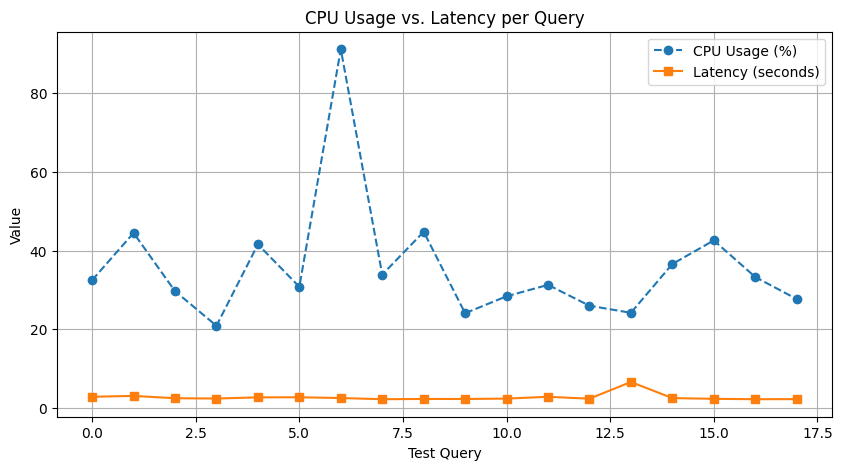

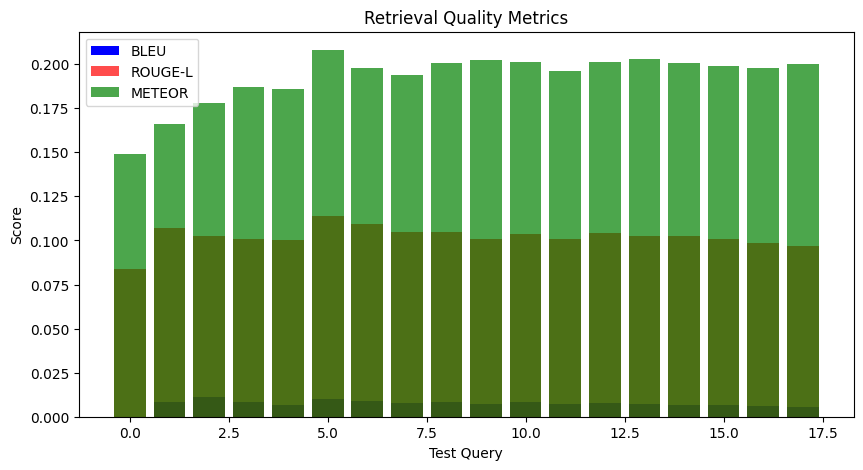

In [11]:
# Set paths
VECTORSTORE_PATH = r"C:\chromadb\landmarks"
TEST_SET_PATH = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\RAG Tests\lm_test01\rag_test_queries.json"
RESULTS_OUTPUT_PATH = r"C:\Users\larry\OneDrive\Documents\GitHub\project-aieng-interactive-travel-planner\RAG Tests\lm_test01\rag_evaluation_results.json"

# Load embeddings & vectorstore
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=VECTORSTORE_PATH, embedding_function=embeddings)

# Load test queries
with open(TEST_SET_PATH, "r", encoding="utf-8") as f:
    test_queries = json.load(f)

# Initialize performance log
evaluation_results = []

def measure_cpu():
    """Returns CPU usage as a percentage."""
    return psutil.cpu_percent(interval=1)

def evaluate_retrieval(query):
    """Runs the query, retrieves documents, measures similarity, and evaluates the response."""
    start_time = time.time()
    cpu_before = measure_cpu()

    # Run retrieval
    docs = vectorstore.similarity_search(query, k=3)  # Using top-k = 3

    cpu_after = measure_cpu()
    latency = time.time() - start_time

    # Extract retrieved texts
    retrieved_texts = [doc.page_content for doc in docs]
    retrieved_titles = [doc.metadata.get("title", "Unknown") for doc in docs]

    return retrieved_texts, retrieved_titles, cpu_before, cpu_after, latency

# Initialize evaluation metrics
rouge = Rouge()
rouge_scores, meteor_scores, bleu_scores = [], [], []

# Run evaluation on all queries
for entry in test_queries:
    query = entry["query"]
    expected_answers = entry["expected_answers"]

    # Retrieve the text using the RAG retriever
    retrieved_texts, retrieved_titles, cpu_before, cpu_after, latency = evaluate_retrieval(query)

    # Tokenize the expected answers and retrieved texts for METEOR
    expected_tokens = [word_tokenize(answer) for answer in expected_answers]
    retrieved_tokens = word_tokenize(" ".join(retrieved_texts))

    # Calculate evaluation metrics
    rouge_score = rouge.get_scores(" ".join(retrieved_texts), " ".join(expected_answers))[0]["rouge-l"]["f"]
    meteor_score_value = meteor_score(expected_tokens, retrieved_tokens)
    bleu_score = sentence_bleu([answer.split() for answer in expected_answers], " ".join(retrieved_texts).split())

    rouge_scores.append(rouge_score)
    meteor_scores.append(meteor_score_value)
    bleu_scores.append(bleu_score)

    avg_rouge = sum(rouge_scores) / len(rouge_scores)
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)

    # Log results
    result_entry = {
        "query": query,
        "expected_answers": expected_answers,
        "retrieved_texts": retrieved_texts,
        "retrieved_titles": retrieved_titles,
        "retrieval_scores": {
            "ROUGE-L": avg_rouge,
            "METEOR": avg_meteor,
            "BLEU": avg_bleu
        },
        "cpu_usage": f"{cpu_before}% -> {cpu_after}%",
        "latency": f"{latency:.4f} seconds"
    }
    evaluation_results.append(result_entry)

# Save results
with open(RESULTS_OUTPUT_PATH, "w", encoding="utf-8") as f:
    json.dump(evaluation_results, f, indent=4, ensure_ascii=False)

print(f"RAG evaluation completed. Results saved to {RESULTS_OUTPUT_PATH}")

# Visualization (CPU vs. Latency)
cpu_usage_data = [float(entry["cpu_usage"].split("->")[1].strip()[:-1]) for entry in evaluation_results]
latency_data = [float(entry["latency"].split()[0]) for entry in evaluation_results]

plt.figure(figsize=(10, 5))
plt.plot(cpu_usage_data, label="CPU Usage (%)", marker="o", linestyle="--")
plt.plot(latency_data, label="Latency (seconds)", marker="s", linestyle="-")
plt.xlabel("Test Query")
plt.ylabel("Value")
plt.title("CPU Usage vs. Latency per Query")
plt.legend()
plt.grid(True)
plt.show()

# Visualization (Retrieval Scores)
bleu_scores = [entry["retrieval_scores"]["BLEU"] for entry in evaluation_results]
rouge_scores = [entry["retrieval_scores"]["ROUGE-L"] for entry in evaluation_results]
meteor_scores = [entry["retrieval_scores"]["METEOR"] for entry in evaluation_results]

plt.figure(figsize=(10, 5))
plt.bar(range(len(bleu_scores)), bleu_scores, color="blue", label="BLEU")
plt.bar(range(len(rouge_scores)), rouge_scores, color="red", label="ROUGE-L", alpha=0.7)
plt.bar(range(len(meteor_scores)), meteor_scores, color="green", label="METEOR", alpha=0.7)
plt.xlabel("Test Query")
plt.ylabel("Score")
plt.title("Retrieval Quality Metrics")
plt.legend()
plt.show()